## Demand Forecasting

Data: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data
XGBoost: https://machinelearningmastery.com/xgboost-for-regression/
LSTM Univariate Predictions using PyTorch: https://www.youtube.com/watch?v=AvKSPZ7oyVg

Predicting future sales based on past data. Predicting sales 1 year into the future. Using XGBoost as baseline, expanding to an LSTM approach.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
store = 1
item = 13

In [3]:
train_data = pd.read_csv('./demand_forecasting/train.csv')
test_data = pd.read_csv('./demand_forecasting/test.csv')
train_data, test_data

(              date  store  item  sales
 0       2013-01-01      1     1     13
 1       2013-01-02      1     1     11
 2       2013-01-03      1     1     14
 3       2013-01-04      1     1     13
 4       2013-01-05      1     1     10
 ...            ...    ...   ...    ...
 912995  2017-12-27     10    50     63
 912996  2017-12-28     10    50     59
 912997  2017-12-29     10    50     74
 912998  2017-12-30     10    50     62
 912999  2017-12-31     10    50     82
 
 [913000 rows x 4 columns],
           id        date  store  item
 0          0  2018-01-01      1     1
 1          1  2018-01-02      1     1
 2          2  2018-01-03      1     1
 3          3  2018-01-04      1     1
 4          4  2018-01-05      1     1
 ...      ...         ...    ...   ...
 44995  44995  2018-03-27     10    50
 44996  44996  2018-03-28     10    50
 44997  44997  2018-03-29     10    50
 44998  44998  2018-03-30     10    50
 44999  44999  2018-03-31     10    50
 
 [45000 rows x 4 col

In [4]:
train_data[['store', 'item', 'sales']].groupby(by=['store']).mean()

,item,sales
store,,
1,25.5,47.268379
2,25.5,67.033165
3,25.5,59.530602
4,25.5,54.902946
5,25.5,39.770164
6,25.5,39.733516
7,25.5,36.363735
8,25.5,64.142048
9,25.5,55.049025


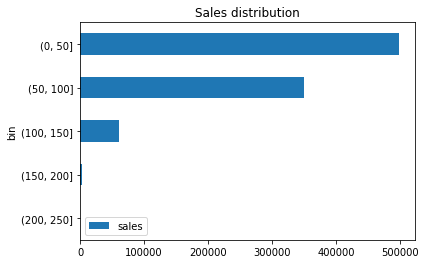

In [5]:
train_data_statistics = train_data.copy()

train_data_statistics['bin'] = pd.cut(train_data['sales'], [0, 50, 100, 150, 200, 250])
sales_bins = train_data_statistics[['bin', 'sales']].groupby(by=['bin']).count()

sales_bins.sort_values(by='sales', ascending=True).plot(kind='barh', title='Sales distribution', );

In [6]:
train = train_data[(train_data['store'] == store) & (train_data['item'] == item)][['date', 'sales']].copy()
test = test_data[(test_data['store'] == store) & (test_data['item'] == item)][['date']].copy()

train, test

(              date  sales
 219120  2013-01-01     37
 219121  2013-01-02     31
 219122  2013-01-03     50
 219123  2013-01-04     45
 219124  2013-01-05     49
 ...            ...    ...
 220941  2017-12-27     49
 220942  2017-12-28     68
 220943  2017-12-29     73
 220944  2017-12-30     70
 220945  2017-12-31     75
 
 [1826 rows x 2 columns],
              date
 10800  2018-01-01
 10801  2018-01-02
 10802  2018-01-03
 10803  2018-01-04
 10804  2018-01-05
 ...           ...
 10885  2018-03-27
 10886  2018-03-28
 10887  2018-03-29
 10888  2018-03-30
 10889  2018-03-31
 
 [90 rows x 1 columns])

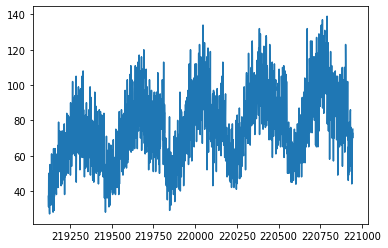

In [8]:
plt.plot(train['sales'])
plt.show()

In [9]:
def convert_date(data):
    data['parsed_date'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d'))
    return data

def split_date(data):
    data['year'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').year)
    data['month'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').month)
    data['day'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').day)
    data['dayofweek'] = data['date'].apply(lambda date: datetime.strptime(date, '%Y-%m-%d').weekday())
    return data
    
train = split_date(train)
test = split_date(test)
train = convert_date(train)
test = convert_date(test)

train, test

(              date  sales  year  month  day  dayofweek parsed_date
 219120  2013-01-01     37  2013      1    1          1  2013-01-01
 219121  2013-01-02     31  2013      1    2          2  2013-01-02
 219122  2013-01-03     50  2013      1    3          3  2013-01-03
 219123  2013-01-04     45  2013      1    4          4  2013-01-04
 219124  2013-01-05     49  2013      1    5          5  2013-01-05
 ...            ...    ...   ...    ...  ...        ...         ...
 220941  2017-12-27     49  2017     12   27          2  2017-12-27
 220942  2017-12-28     68  2017     12   28          3  2017-12-28
 220943  2017-12-29     73  2017     12   29          4  2017-12-29
 220944  2017-12-30     70  2017     12   30          5  2017-12-30
 220945  2017-12-31     75  2017     12   31          6  2017-12-31
 
 [1826 rows x 7 columns],
              date  year  month  day  dayofweek parsed_date
 10800  2018-01-01  2018      1    1          0  2018-01-01
 10801  2018-01-02  2018      1    2

In [10]:
train = train.set_index('parsed_date')
test = test.set_index('parsed_date')

train, test

(                   date  sales  year  month  day  dayofweek
 parsed_date                                                
 2013-01-01   2013-01-01     37  2013      1    1          1
 2013-01-02   2013-01-02     31  2013      1    2          2
 2013-01-03   2013-01-03     50  2013      1    3          3
 2013-01-04   2013-01-04     45  2013      1    4          4
 2013-01-05   2013-01-05     49  2013      1    5          5
 ...                 ...    ...   ...    ...  ...        ...
 2017-12-27   2017-12-27     49  2017     12   27          2
 2017-12-28   2017-12-28     68  2017     12   28          3
 2017-12-29   2017-12-29     73  2017     12   29          4
 2017-12-30   2017-12-30     70  2017     12   30          5
 2017-12-31   2017-12-31     75  2017     12   31          6
 
 [1826 rows x 6 columns],
                    date  year  month  day  dayofweek
 parsed_date                                         
 2018-01-01   2018-01-01  2018      1    1          0
 2018-01-02   201

In [11]:
sales = train['sales'].to_dict()
train['last_year_sales'] = (train.index - pd.Timedelta('364 days')).map(sales)
test['last_year_sales'] = (test.index - pd.Timedelta('364 days')).map(sales)

train, test

(                   date  sales  year  month  day  dayofweek  last_year_sales
 parsed_date                                                                 
 2013-01-01   2013-01-01     37  2013      1    1          1              NaN
 2013-01-02   2013-01-02     31  2013      1    2          2              NaN
 2013-01-03   2013-01-03     50  2013      1    3          3              NaN
 2013-01-04   2013-01-04     45  2013      1    4          4              NaN
 2013-01-05   2013-01-05     49  2013      1    5          5              NaN
 ...                 ...    ...   ...    ...  ...        ...              ...
 2017-12-27   2017-12-27     49  2017     12   27          2             56.0
 2017-12-28   2017-12-28     68  2017     12   28          3             67.0
 2017-12-29   2017-12-29     73  2017     12   29          4             68.0
 2017-12-30   2017-12-30     70  2017     12   30          5             55.0
 2017-12-31   2017-12-31     75  2017     12   31          6    

In [12]:
training_data = train[['sales', 'year', 'month', 'day', 'dayofweek', 'last_year_sales']]
testing_data = test[['year', 'month', 'day', 'dayofweek', 'last_year_sales']]
training_data, testing_data

(             sales  year  month  day  dayofweek  last_year_sales
 parsed_date                                                     
 2013-01-01      37  2013      1    1          1              NaN
 2013-01-02      31  2013      1    2          2              NaN
 2013-01-03      50  2013      1    3          3              NaN
 2013-01-04      45  2013      1    4          4              NaN
 2013-01-05      49  2013      1    5          5              NaN
 ...            ...   ...    ...  ...        ...              ...
 2017-12-27      49  2017     12   27          2             56.0
 2017-12-28      68  2017     12   28          3             67.0
 2017-12-29      73  2017     12   29          4             68.0
 2017-12-30      70  2017     12   30          5             55.0
 2017-12-31      75  2017     12   31          6             60.0
 
 [1826 rows x 6 columns],
              year  month  day  dayofweek  last_year_sales
 parsed_date                                           

In [13]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

X, y = training_data[['year', 'month', 'day', 'dayofweek', 'last_year_sales']].values, training_data[['sales']].values

model = XGBRegressor(n_estimators=100, early_stopping_rounds=10)

In [14]:
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 8.287 (0.276)


[22:02:18] WARNING: /workspace/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:55.51581	validation_1-rmse:56.39554
[1]	validation_0-rmse:39.73651	validation_1-rmse:40.44435
[2]	validation_0-rmse:28.84868	validation_1-rmse:29.45292
[3]	validation_0-rmse:21.42018	validation_1-rmse:22.15765
[4]	validation_0-rmse:16.37955	validation_1-rmse:17.28013
[5]	validation_0-rmse:13.11291	validation_1-rmse:14.20989
[6]	validation_0-rmse:11.02534	validation_1-rmse:12.47640
[7]	validation_0-rmse:9.67009	validation_1-rmse:11.33219
[8]	validation_0-rmse:8.80871	validation_1-rmse:10.70605
[9]	validation_0-rmse:8.27749	validation_1-rmse:10.30851
[10]	validation_0-rmse:7.94249	validation_1

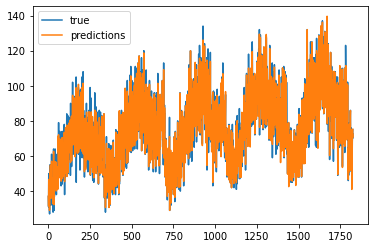

MAE on test: 7.976, RMSE on test: 10.206


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
predictions = model.predict(X)

plt.plot(y, label='true')
plt.plot(predictions, label='predictions')
plt.legend(loc='best')
plt.show()

y_pred = model.predict(X_test)
mae_error = mean_absolute_error(y_test, y_pred)
rmse_error = np.sqrt(mean_squared_error(y_test, y_pred))

print('MAE on test: %.3f, RMSE on test: %.3f' % (mae_error, rmse_error))

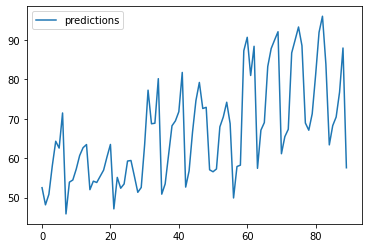

In [16]:
X_testing = testing_data[['year', 'month', 'day', 'dayofweek', 'last_year_sales']].values

y_predictions = model.predict(X_testing)

plt.plot(y_predictions, label='predictions')
plt.legend(loc='best')
plt.show()

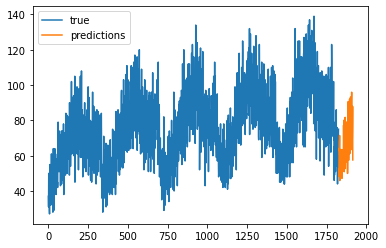

In [18]:
plt.plot(y, label='true')
plt.plot(range(len(y), len(y)+len(y_predictions)), y_predictions.reshape(-1, 1), label='predictions')
plt.legend(loc='best')
plt.show()

In [20]:
feature_map = { 'f' + str(index): value for index, value in enumerate(['year', 'month', 'day', 'dayofweek', 'last_year_sales']) }
weights = model.get_booster().get_score(importance_type='weight')
weights = pd.DataFrame.from_dict({ feature_map[key]: value for key, value in weights.items() }, orient='index', columns=['weight'])

weights.sort_values(by=['weight'], ascending=False)

,weight
day,1314.0
last_year_sales,1282.0
month,907.0
dayofweek,614.0
year,525.0


## Vanilla LSTM Approach

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

values = train[['sales']].values

scaler.fit(values)

train['normalized_sales'] = scaler.transform(train[['sales']])

train

,date,sales,year,month,day,dayofweek,last_year_sales,normalized_sales
parsed_date,,,,,,,,
2013-01-01,2013-01-01,37,2013,1,1,1,NaN,0.089286
2013-01-02,2013-01-02,31,2013,1,2,2,NaN,0.035714
2013-01-03,2013-01-03,50,2013,1,3,3,NaN,0.205357
2013-01-04,2013-01-04,45,2013,1,4,4,NaN,0.160714
2013-01-05,2013-01-05,49,2013,1,5,5,NaN,0.196429
...,...,...,...,...,...,...,...,...
2017-12-27,2017-12-27,49,2017,12,27,2,56.0,0.196429
2017-12-28,2017-12-28,68,2017,12,28,3,67.0,0.366071
2017-12-29,2017-12-29,73,2017,12,29,4,68.0,0.410714


In [22]:
normalized_sales = train['normalized_sales'].to_dict()
train['sales_1'] = (train.index - pd.Timedelta('365 days')).map(normalized_sales)
train['sales_2'] = (train.index - pd.Timedelta('366 days')).map(normalized_sales)
train['sales_3'] = (train.index - pd.Timedelta('367 days')).map(normalized_sales)
train['sales_4'] = (train.index - pd.Timedelta('368 days')).map(normalized_sales)
train['sales_5'] = (train.index - pd.Timedelta('369 days')).map(normalized_sales)
train['sales_6'] = (train.index - pd.Timedelta('370 days')).map(normalized_sales)
train['sales_7'] = (train.index - pd.Timedelta('371 days')).map(normalized_sales)
test['sales_1'] = (test.index - pd.Timedelta('365 days')).map(normalized_sales)
test['sales_2'] = (test.index - pd.Timedelta('366 days')).map(normalized_sales)
test['sales_3'] = (test.index - pd.Timedelta('367 days')).map(normalized_sales)
test['sales_4'] = (test.index - pd.Timedelta('368 days')).map(normalized_sales)
test['sales_5'] = (test.index - pd.Timedelta('369 days')).map(normalized_sales)
test['sales_6'] = (test.index - pd.Timedelta('370 days')).map(normalized_sales)
test['sales_7'] = (test.index - pd.Timedelta('371 days')).map(normalized_sales)

train = train.dropna()
test = test.dropna()

train, test

(                   date  sales  year  month  day  dayofweek  last_year_sales  \
 parsed_date                                                                    
 2014-01-07   2014-01-07     54  2014      1    7          1             27.0   
 2014-01-08   2014-01-08     39  2014      1    8          2             37.0   
 2014-01-09   2014-01-09     51  2014      1    9          3             45.0   
 2014-01-10   2014-01-10     66  2014      1   10          4             55.0   
 2014-01-11   2014-01-11     42  2014      1   11          5             45.0   
 ...                 ...    ...   ...    ...  ...        ...              ...   
 2017-12-27   2017-12-27     49  2017     12   27          2             56.0   
 2017-12-28   2017-12-28     68  2017     12   28          3             67.0   
 2017-12-29   2017-12-29     73  2017     12   29          4             68.0   
 2017-12-30   2017-12-30     70  2017     12   30          5             55.0   
 2017-12-31   2017-12-31    

In [23]:
train_X = train[['sales_7', 'sales_6', 'sales_5', 'sales_4', 'sales_3', 'sales_2', 'sales_1']].values
test_X = test[['sales_7', 'sales_6', 'sales_5', 'sales_4', 'sales_3', 'sales_2', 'sales_1']].values
train_y = train[['normalized_sales']].values

train_X.shape, test_X.shape, train_y.shape

((1455, 7), (90, 7), (1455, 1))

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [25]:
training_tensors = np.concatenate((train_X, train_y), axis=1)

train_tensors, val_tensors = train_test_split(training_tensors, test_size=0.1, shuffle=True)

training_tensors = torch.from_numpy(training_tensors).float()
train_tensors = torch.from_numpy(train_tensors).float()
val_tensors = torch.from_numpy(val_tensors).float()
test_X = torch.from_numpy(test_X).float()

training_tensors.shape, train_tensors.shape, val_tensors.shape, test_X.shape

(torch.Size([1455, 8]),
 torch.Size([1309, 8]),
 torch.Size([146, 8]),
 torch.Size([90, 7]))

In [26]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda')

In [27]:
class LSTMRegressor(nn.Module):
    def __init__(self):
        super(LSTMRegressor, self).__init__()
        
        self.lstm1 = nn.LSTMCell(1, 64)
        self.lstm2 = nn.LSTMCell(64, 64)
        self.regressor = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 8),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        hidden_state_1 = torch.zeros((x.shape[0], 64), dtype=torch.float32).to(device)
        cell_state_1 = torch.zeros((x.shape[0], 64), dtype=torch.float32).to(device)
        hidden_state_2 = torch.zeros((x.shape[0], 64), dtype=torch.float32).to(device)
        cell_state_2 = torch.zeros((x.shape[0], 64), dtype=torch.float32).to(device)
        
        for input in torch.split(x, 1, dim=1):
            hidden_state_1, cell_state_1 = self.lstm1(input, (hidden_state_1, cell_state_1))
            hidden_state_2, cell_state_2 = self.lstm2(hidden_state_1, (hidden_state_2, cell_state_2))
        outputs = self.regressor(hidden_state_2)
        
        return outputs
    
model = LSTMRegressor().to(device)

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_function = nn.MSELoss()

losses = []
validation_losses = []

for epoch in range(20):
    print('Epoch:', epoch+1)
    epoch_losses = []
    model.train()
    for batch in torch.split(train_tensors, 8, dim=0):
        x = batch[:, :-1].to(device)
        y = batch[:, -1:].to(device)
    
        model.zero_grad()
        outputs = model(x)
        
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print('Mean Loss:', np.mean(epoch_losses))
    losses.append(np.mean(epoch_losses))
    
    model.eval()
    with torch.no_grad():
        x = val_tensors[:, :-1].to(device)
        y = val_tensors[:, -1:].to(device)
        outputs = model(x)
        loss = loss_function(outputs, y)
    print('Validation Loss:', loss.item())
    validation_losses.append(loss.item())

Epoch: 1
Mean Loss: 0.06548721952045836
Validation Loss: 0.02881825715303421
Epoch: 2
Mean Loss: 0.02724389193534124
Validation Loss: 0.029073381796479225
Epoch: 3
Mean Loss: 0.02485971561229856
Validation Loss: 0.026829034090042114
Epoch: 4
Mean Loss: 0.02422831510193646
Validation Loss: 0.02708393707871437
Epoch: 5
Mean Loss: 0.02210649112580208
Validation Loss: 0.02022552117705345
Epoch: 6
Mean Loss: 0.020428781552387903
Validation Loss: 0.020943136885762215
Epoch: 7
Mean Loss: 0.019637059685830936
Validation Loss: 0.018702762201428413
Epoch: 8
Mean Loss: 0.01895087090939874
Validation Loss: 0.019467752426862717
Epoch: 9
Mean Loss: 0.018507535076734225
Validation Loss: 0.018392853438854218
Epoch: 10
Mean Loss: 0.017538857465984707
Validation Loss: 0.018387997522950172
Epoch: 11
Mean Loss: 0.0162780265261351
Validation Loss: 0.01807643286883831
Epoch: 12
Mean Loss: 0.016896991301242763
Validation Loss: 0.016920605674386024
Epoch: 13
Mean Loss: 0.016449610522391682
Validation Loss: 0.

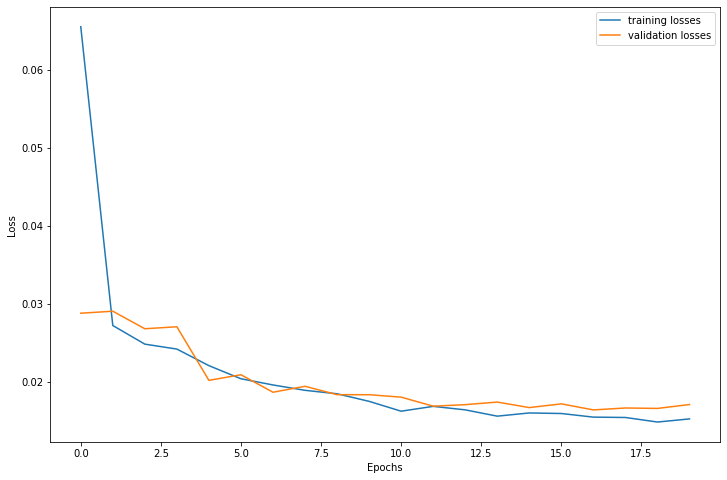

In [29]:
plt.figure(figsize=(12, 8))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses, label='training losses')
plt.plot(validation_losses, label='validation losses')
plt.legend(loc='best')
plt.show()

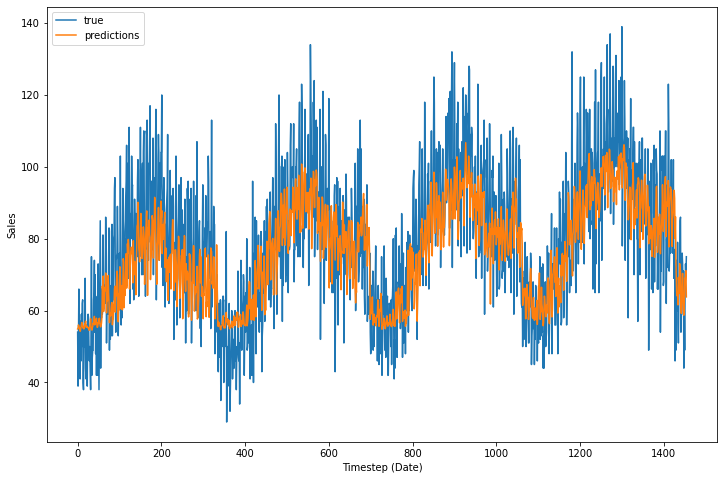

In [30]:
model.eval()
x = training_tensors[:, :-1].to(device)
y_true = scaler.inverse_transform(training_tensors[:, -1:])
with torch.no_grad():
    y_pred = scaler.inverse_transform(model(x).detach().cpu().numpy())

plt.figure(figsize=(12, 8))
plt.xlabel('Timestep (Date)')
plt.ylabel('Sales')
plt.plot(y_true, label='true')
plt.plot(y_pred, label='predictions')
plt.legend(loc='best')
plt.show()

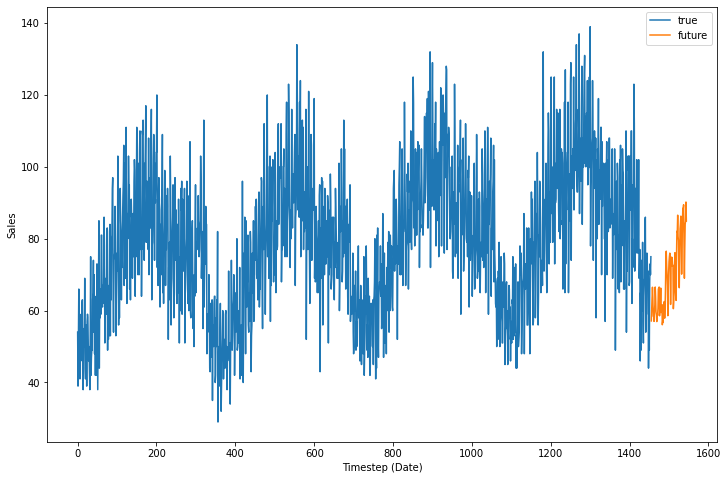

In [31]:
model.eval()
x = test_X.to(device)
y_real = scaler.inverse_transform(training_tensors[:, -1:])
with torch.no_grad():
    y_future = scaler.inverse_transform(model(x).detach().cpu().numpy())

plt.figure(figsize=(12, 8))
plt.xlabel('Timestep (Date)')
plt.ylabel('Sales')
plt.plot(y_real, label='true')
plt.plot(range(len(y_real), len(y_real)+len(y_future)), y_future, label='future')
plt.legend(loc='best')
plt.show()

In [34]:
model.eval()
x = training_tensors[:, :-1].to(device)
y_true = scaler.inverse_transform(training_tensors[:, -1:])
with torch.no_grad():
    y_pred = scaler.inverse_transform(model(x).detach().cpu().numpy())

loss = loss_function(torch.from_numpy(y_pred).float(), torch.from_numpy(y_true).float())

print('Average MSE:', loss.item())

Average MSE: 174.3832244873047


In [32]:
torch.save(model, 'lstmregressor.bin')